# Assignment

How can we use Bayesian models to compare two distributions? It turns out that we can compare Bayesian models in several ways. In this assignment, we will compute and compare credible intervals of the posterior distribution of a model parameter.

Before we begin, let's load the libraries and functions we need.

In [155]:
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import seaborn as sns
import scipy.stats as ss
import statsmodels.stats.weightstats as ws
import scipy
import itertools
import pymc3 as pm
import arviz as az

In [156]:
def posterior(prior, like):
    post = prior * like # compute the product of the probabilities
    return post / post.sum() # normalize the distribution to sum to unity

num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(p, post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))


For this example, we will compare the posterior distribution of the heights of sons to the heights of the mothers in the Galton family dataset. As a first step, we will compute and evaluate Bayesian models for the mean heights using a subset of just 25 observations.

In [157]:
families = pd.read_csv('GaltonFamilies.csv', index_col = 0)
families.head()

,father,mother,midparentHeight,children,childNum,gender,childHeight
family,,,,,,,
001,78.5,67.0,75.43,4,1,male,73.2
001,78.5,67.0,75.43,4,2,female,69.2
001,78.5,67.0,75.43,4,3,female,69.0
001,78.5,67.0,75.43,4,4,female,69.0
002,75.5,66.5,73.66,4,1,male,73.5


- Plot the distributions of the height of mothers and sons for a sample of size 25. Do the distributions appear to be significantly different? <span style="color:red" float:right>[5 point]</span>

In [158]:
#Go back and make sure that the sample size is based on male - not males and females

num_samples = 25
np.random.seed(1)
families.reset_index(inplace=True)
#fam_25 = families.groupby(['family', 'mother', 'childHeight']).count().sample(n=num_samples)
male_25 = families[families['gender']=='male'].sample(n=num_samples)
#fam_25.reset_index(inplace=True)
#fam_25.head()
male_25.head()

,family,father,mother,midparentHeight,children,childNum,gender,childHeight
579,130,68.5,66.5,70.16,11,5,male,68.5
565,126,69.0,60.0,66.90,4,1,male,69.0
80,022,72.0,67.0,72.18,3,2,male,71.0
768,168,67.0,63.5,67.79,8,5,male,68.0
831,181,66.5,62.5,67.00,7,1,male,70.0


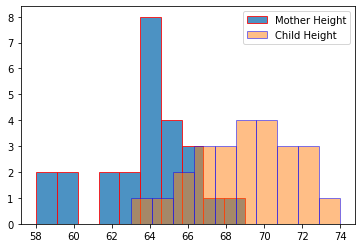

In [159]:
plt.hist(male_25['mother'], label = 'Mother Height', alpha=0.8, edgecolor='red')
plt.hist(male_25['childHeight'], label = 'Child Height', alpha=0.5, edgecolor='blue')
plt.legend()
plt.show()

In [160]:
mother = families['mother']
child = families['childHeight']

print(type([mother,child]))

<class 'list'>


def t_test_height(a, b, alpha = 0.05, alternative = 'two-sided', type = 'independent'):

    diff = a.mean() - b.mean()
    if type == 'independent':
        res = ss.ttest_ind(a, b, equal_var = False)
    elif type == 'paired':
        assert(len(a) == len(b))
        res = ss.ttest_rel(a, b)
      
    means = ws.CompareMeans(ws.DescrStatsW(a), ws.DescrStatsW(b))
    confint = means.tconfint_diff(alpha = alpha, alternative = alternative, usevar = 'unequal') 
    degfree = means.dof_satt()

    index = ['deg_of_freedom', 'observed_difference', 't-statistic', 'p_value', 'low_95_CI', 'high_95_CI']
    return pd.Series([degfree, diff, res[0], res[1], confint[0], confint[1]], index = index)   
   

t_test_height(mother, child)

- Yes, the distributions do appear to be different and are statistically verified by T-Test

To perform this analysis, we need to select a prior distribution, which is easy, and to compute the likelihood, which is not as easy. So first, let's see how we can get the likelihood.

For this data, we will use a normal likelihood. For something like heights, using the normal distribution makes sense. For any individual sample  𝑋  if it follows the normal distribution with mean  𝜇  and standard deviation  𝜎 , then it probability density function is given by

𝑋∼𝑁(𝜇,𝜎)⇒𝑃(𝑋|𝜇,𝜎)=12𝜋𝜎2⎯⎯⎯⎯⎯⎯⎯⎯√exp[−12(𝑋−𝜇𝜎)2]
 
For a sample  𝑋1,𝑋2,⋯,𝑋𝑛  of  𝑛  independent normally distributed observations has the following likelihood:

𝑃(𝑋1,𝑋2,⋯,𝑋𝑛|𝜇,𝜎)=∏𝑖=1𝑛𝑃(𝑋𝑖|𝜇,𝜎)=∏𝑖=1𝑛12𝜋𝜎2⎯⎯⎯⎯⎯⎯⎯⎯√exp[−12(𝑋𝑖−𝜇𝜎)2]
 
Notice that we multiply the individual the probabilities to get the likelihood. We can do this because we assume that the data points are independent. This seems like a relatively safe assumption.

Now let's simplify the above equation. We can simplify things by ignoring the terms outside the exponential, since they don't depend on the sample, and replacing  =  (is equal to) with  ∝  (is proportional to):

𝑃(𝑋1,𝑋2,⋯,𝑋𝑛|𝜇,𝜎)∝∏𝑖=1𝑛exp[−12(𝑋𝑖−𝜇𝜎)2]
 
Moreover, we can rely on the property  𝑒𝑎𝑒𝑏=𝑒𝑎+𝑏  to rewrite the right-hand side as

𝑃(𝑋1,𝑋2,⋯,𝑋𝑛|𝜇,𝜎)∝exp[−12∑𝑖=1𝑛(𝑋𝑖−𝜇𝜎)2]
 
Finally, letting  𝑋¯=1𝑛∑𝑛𝑖=1𝑋𝑖  we can rewrite  𝑋𝑖−𝜇  as  𝑋𝑖−𝑋¯+𝑋¯−𝜇  and after some rearranging we get this:

𝑃(𝑋1,𝑋2,⋯,𝑋𝑛|𝜇,𝜎)∝exp[−12𝜎2(∑𝑖=1𝑛(𝑋𝑖−𝑋¯)2+𝑛(𝑋¯−𝜇)2)]
 
To simplify the computations here, we will only estimate the posterior distribution of  𝜇 . We will use a fixed empirical estimate of the standard deviation. A more complete analysis will also estimate the posterior distribution of  𝜎 .

- Now your task is to write a function called `likelihood` that computes the likelihood as given by the above equation. The input of the function is `mu` (the parameter) and `x` (the data) and its output is the likelihood of the data given the parameter. You may find it helpful to use `np.exp` and `np.sum`. <span style="color:red" float:right>[10 point]</span>

Scracth and Notes

- https://towardsdatascience.com/how-to-impliment-a-gaussian-naive-bayes-classifier-in-python-from-scratch-11e0b80faf5a
- https://towardsdatascience.com/conducting-bayesian-inference-in-python-using-pymc3-d407f8d934a5

Want to check the mean of the samples first

In [164]:
male_25.describe()

,father,mother,midparentHeight,children,childNum,childHeight
count,25.00000,25.000000,25.000000,25.000000,25.000000,25.000000
mean,69.08800,63.680000,68.931200,6.640000,2.720000,68.924000
std,1.78823,2.569371,1.795572,2.706166,1.671327,2.642013
min,66.50000,58.000000,65.860000,1.000000,1.000000,63.000000
25%,68.00000,62.500000,67.790000,5.000000,2.000000,67.000000
50%,68.50000,64.000000,68.730000,7.000000,2.000000,68.700000
75%,70.50000,65.000000,69.790000,8.000000,4.000000,71.000000
max,72.70000,69.000000,73.610000,11.000000,7.000000,74.000000


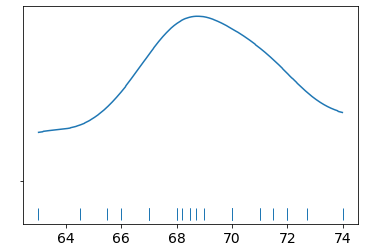

In [163]:
az.plot_kde(male_25['childHeight'].values, rug=True)
plt.yticks([0], alpha=0);

In [134]:
def likelihood(mu, data):
#    CRAP=[((i - data.mean())**2) + (len(data))*((data.mean() - 67)**2) for i in data]
#    LAME=np.exp((-(1/(2*((np.var(data))**2))))*np.sum(lame))
#    return CRAP
    x_bar = data.mean()#Call of the column
    sigma = data.std()
    for x in mu:
        l = scipy.stats.
        #Plug in formula and run from there
        #Standardize the results
        
        
    #Look above at car - n, k, p - p is the continuous variable
    ##sigma (likelihood) here has 3 variable, x_bar, x_i, and mu - in both cases, p and mu are both continous variables
    #Just need to standardize the equation down below
    #create it as numpy arrays - will then be vectorized
    #Should be 1000 samples
    #for fixed x_bar - sample mean
    #for sigma - sample variance

Now for the prior distribution, we will use a normal distribution centered at 70 with standard deviation 1. The code for the prior is already written. Examine it and make sure you understand each step.

In [135]:
N = 1000
mu = np.linspace(60, 80, num = N)
prior_center = 70
prior = scipy.stats.norm.pdf(mu, loc = prior_center, scale = 1)
prior = prior / prior.sum() # normalize

Now we're ready to compute the posterior for both mother and son.

- Compute the posterior distribution for the sons (the column name is childHeight). You will need to compute the likelihood first. Then plot the prior, posterior and likelihood just like we did in class. [10 point]

In [138]:
#Also calculated above in .describe() call
std = np.r_[families.childHeight].std()
std

3.5773346010057634

In [148]:
like = likelihood(mu, fam_25['childHeight'])
like

0.3918429749847048

In [140]:
def posterior(prior, like):
    post = prior * like
    return prior/post.sum()
post = posterior(prior, like)

In [141]:
def plot_pp(x, p, l, pp):
    sns.lineplot(x=x, y=l, color = 'lightgrey', linewidth = 10)
    sns.lineplot(x=x, y=p, color = 'blue', linewidth = 2)
    sns.lineplot(x=x, y=pp, color = 'red', linewidth = 2)
    plt.xlabel('p')
    plt.ylabel('PDF of p')
    plt.title('Prior, likelihood and posterior distributions')
    plt.legend(labels = ['likelihood', 'prior', 'posterior'])
    return None

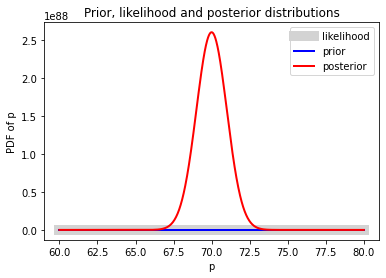

In [142]:
plot_pp(mu, prior, like, post)

- Compute the posterior distribution for mothers (the column name is mother). You will need to compute the likelihood first. Sons and mothers both use the same proir. Then plot the prior, posterior and likelihood just like we did in class. [5 point]

In [144]:
#Same as above - on mother column

To compare the posterior distributions of the mean heights of the sons to the distribution of the mean heights of the mothers, we compute and compare the confidence intervals.

- Use the plot_ci function to plot credible intervals for mother and son heights. You can call the function twice in the same cell and the two distributions will be plotted next to each other in one plot. What conclusion do you draw about the heights of mothers versus sons? [10 point]

In [143]:
#https://scientificallysound.org/2016/03/17/matplotlib-data-visualisation/

In [ ]:
num_samples = 100000
lower_q, upper_q = [.025, .975]

def plot_ci(p, post, num_samples, lower_q, upper_q, **kw):
    ## This function computes a credible interval using an assumption
    ## of symetry in the bulk of the distribution to keep the 
    ## calculation simple. 
    ## Compute a large sample by resampling with replacement
    samples = np.random.choice(p, size = num_samples, replace = True, p = post)
    ci = np.percentile(samples, [lower_q*100, upper_q*100]) # compute the quantiles
    
    interval = upper_q - lower_q
    plt.title('Posterior density with %.3f credible interval' % interval)
    sns.lineplot(x=p, y=post, color = 'blue', **kw)
    plt.xlabel('Parameter value')
    plt.ylabel('Density')
    plt.axvline(x = ci[0], color = 'red')
    plt.axvline(x = ci[1], color = 'red')
    print('The {:0.3f} credible interval is {:0.3f} to {:0.3f}'.format(interval, lower_q, upper_q))
    
plot_ci(x, post, num_samples, lower_q, upper_q)